# Regression Models and Complementary Datasets (Continued)
**Project**: M4 Project 4
**Author**: Jacob Buysse

In this project we will be performing regression modeling on home sale pricing and them combining that dataset with a complimentary dataset to see how it might improve the model performance.

In this notebook we will be using...

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

We will configure our plots for readable labels, high resolution, and automatic layout.

In [2]:
plt.rc("axes", labelsize=18)
plt.rc("figure", dpi=150, autolayout=True)

## Part II

Now we will build and evalutate a predictive model.  Let us start by loading our feather file and showing the info.

In [3]:
df = pd.read_feather("./kc_house_data-cleaned.feather")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20873 entries, 0 to 20872
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   index             20873 non-null  int64   
 1   id                20873 non-null  int64   
 2   date              20873 non-null  object  
 3   price             20873 non-null  float64 
 4   bedrooms          20873 non-null  category
 5   bathrooms         20873 non-null  float64 
 6   sqft_living       20873 non-null  int64   
 7   sqft_lot          20873 non-null  int64   
 8   floors            20873 non-null  float64 
 9   waterfront        20873 non-null  category
 10  view              20873 non-null  category
 11  condition         20873 non-null  category
 12  grade             20873 non-null  category
 13  sqft_above        20873 non-null  int64   
 14  sqft_basement     20873 non-null  int64   
 15  yr_built          20873 non-null  int64   
 16  yr_renovated      2087

### Splitting Price into Bins and Splitting Training/Testing Datasets

Let us use the `histogram_bin_edges` function to split the price feature into bins and then plot the resulting values.

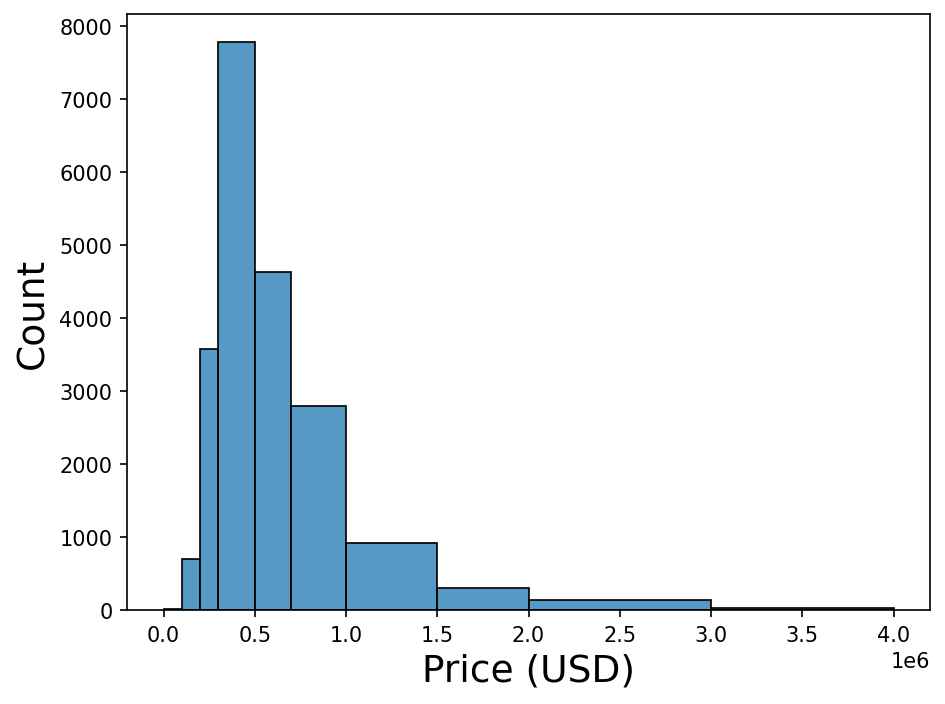

In [4]:
price_bins = np.histogram_bin_edges(df.price, bins=[0, 100000, 200000, 300000, 500000, 700000, 1000000, 1500000, 2000000, 3000000, 4000000])
price_plot = sns.histplot(df.price, bins=price_bins)
price_plot.set(xlabel="Price (USD)", ylabel="Count");

Now let us use the `digitize` function to determine which price bins each row is in and split the rows into a 75% training, 25% testing split.

In [5]:
price_bin_inds = np.digitize(df.price, price_bins)
train_df, test_df = train_test_split(df, train_size=0.75, random_state=777, stratify=price_bin_inds)
print(f"Training size: {train_df.shape}, testing size {test_df.shape}")

Training size: (15654, 27), testing size (5219, 27)


### Feature Encoding

Now let us convert each of the categorical columns we will be using into binary columns using `OneHotEncoder` but only using the training data set.

In [6]:
hot_enc = OneHotEncoder()
cat_features = [
    "bedrooms", "waterfront", "view", "condition", "grade", "zipcode",
    "whole_bathrooms", "partial_bathroom", "whole_floors", "partial_floors"
]
hot_enc.fit(train_df[cat_features])
hot_enc.get_feature_names_out()

array(['bedrooms_1', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4',
       'bedrooms_5', 'bedrooms_6', 'bedrooms_7', 'bedrooms_8',
       'waterfront_0', 'waterfront_1', 'view_0', 'view_1', 'view_2',
       'view_3', 'view_4', 'condition_1', 'condition_2', 'condition_3',
       'condition_4', 'condition_5', 'grade_4', 'grade_5', 'grade_6',
       'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11',
       'grade_12', 'grade_13', 'zipcode_98001', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'z

And now let us get the one hot encoding features for these categorical features.

In [7]:
train_hot = hot_enc.transform(train_df[cat_features])
train_hot.shape

(15654, 115)

In [8]:
test_hot = hot_enc.transform(test_df[cat_features])
test_hot.shape

(5219, 115)

### Feature Scaling

Now let us scale each of the numeric features using the `StandardScaler`.

In [9]:
scaler = StandardScaler()
num_features = [
    "sqft_living", "sqft_lot", "sqft_above", "sqft_basement",
    "yr_built", "yr_renovated", "lat", "long", "yr_sold"
]
scaler.fit(train_df[num_features])
train_num = scaler.transform(train_df[num_features])
train_num.shape

(15654, 9)

In [10]:
test_num = scaler.transform(test_df[num_features])
test_num.shape

(5219, 9)

### Prepare inputs for regression models

Let us do the final train_X, train_y, test_X, and test_y creation.

In [11]:
train_X = sp.hstack((train_hot, train_num))
train_y = train_df.price.values
test_X = sp.hstack((test_hot, test_num))
test_y = test_df.price.values
print(f"Train X {train_X.shape}, y {len(train_y)}")
print(f"Test X {test_X.shape}, y {len(test_y)}")

Train X (15654, 124), y 15654
Test X (5219, 124), y 5219


### Baseline Model - Ridge Regression

Now we will use Ridge regression to train a model, test it, and score it.

In [12]:
model = Ridge(random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
pred_y

array([545607.07243606, 390997.17803591, 433815.30026694, ...,
       981460.70592896, 245725.22613518, 305788.3934394 ])

In [13]:
mse = mean_squared_error(test_y, pred_y)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_y, pred_y)
print(f"RMSE (USD): ${rmse:,.0f}, MAPE: {mape:.1%}")

RMSE (USD): $134,022, MAPE: 16.2%


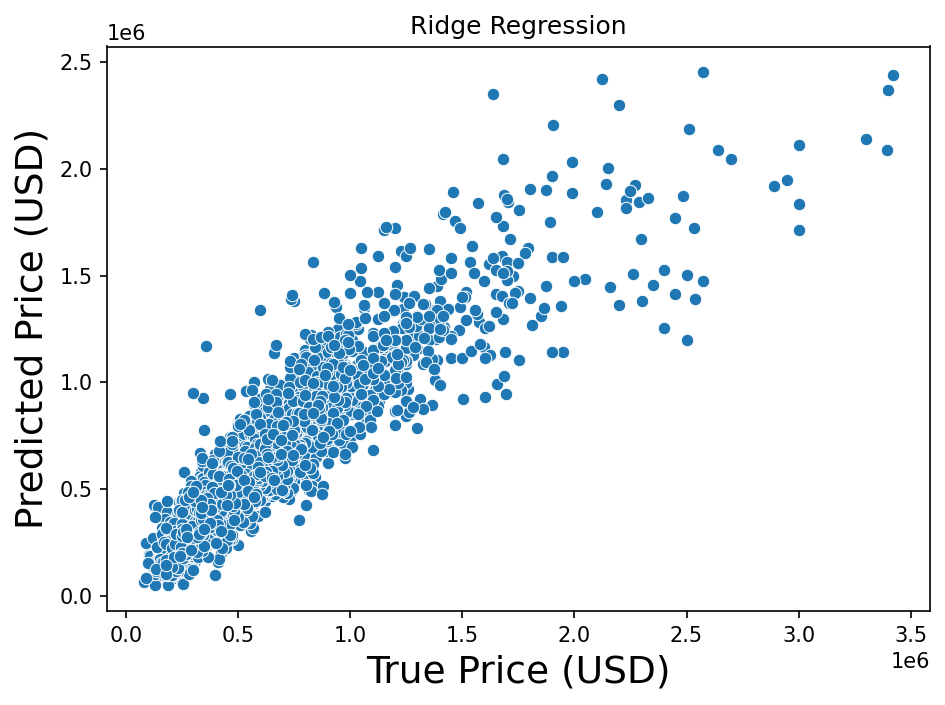

In [14]:
pred_true_plot = sns.scatterplot(x=test_y, y=pred_y)
pred_true_plot.set(xlabel="True Price (USD)", ylabel="Predicted Price (USD)", title="Ridge Regression");

### Alternate Model 1 - SGD Regressor

Let us switch our model to the `SGDRegressor` class and the "huber" loss function (tweaking epsilon to a high value and upping the maximum iterations).

In [15]:
model = SGDRegressor(loss="huber", epsilon=50000, max_iter=10000, random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
pred_y

array([542166.18329536, 386436.44214488, 462819.31086351, ...,
       927710.50677003, 262437.70960115, 319093.08796848])

In [16]:
mse = mean_squared_error(test_y, pred_y)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_y, pred_y)
print(f"RMSE (USD): ${rmse:,.0f}, MAPE: {mape:.1%}")

RMSE (USD): $150,212, MAPE: 14.7%


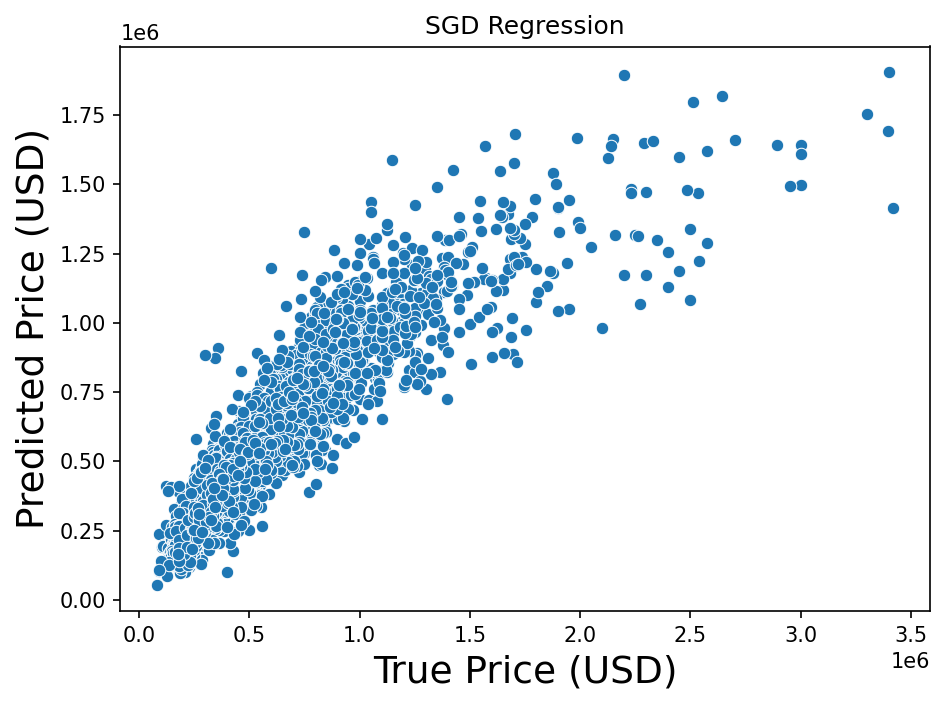

In [17]:
pred_true_plot = sns.scatterplot(x=test_y, y=pred_y)
pred_true_plot.set(xlabel="True Price (USD)", ylabel="Predicted Price (USD)", title="SGD Regression");

We can see the RMSE is slightly higher and the MAPE is slightly lower.  The predicted vs. true price graphs are relatively equivalent.

### Alternate Model 2 - Random Forest Regressor

Let us switch our model to the `RandomForestRegressor` class (capping the depth at 10 so it has a chance to complete in a reasonable amount of time).

In [18]:
model = RandomForestRegressor(max_depth=10, random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
pred_y

array([ 555986.63123168,  446355.98350569,  500740.14537547, ...,
       1289295.04370639,  319097.25911054,  303049.99827156])

In [19]:
mse = mean_squared_error(test_y, pred_y)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_y, pred_y)
print(f"RMSE (USD): ${rmse:,.0f}, MAPE: {mape:.1%}")

RMSE (USD): $126,394, MAPE: 14.2%


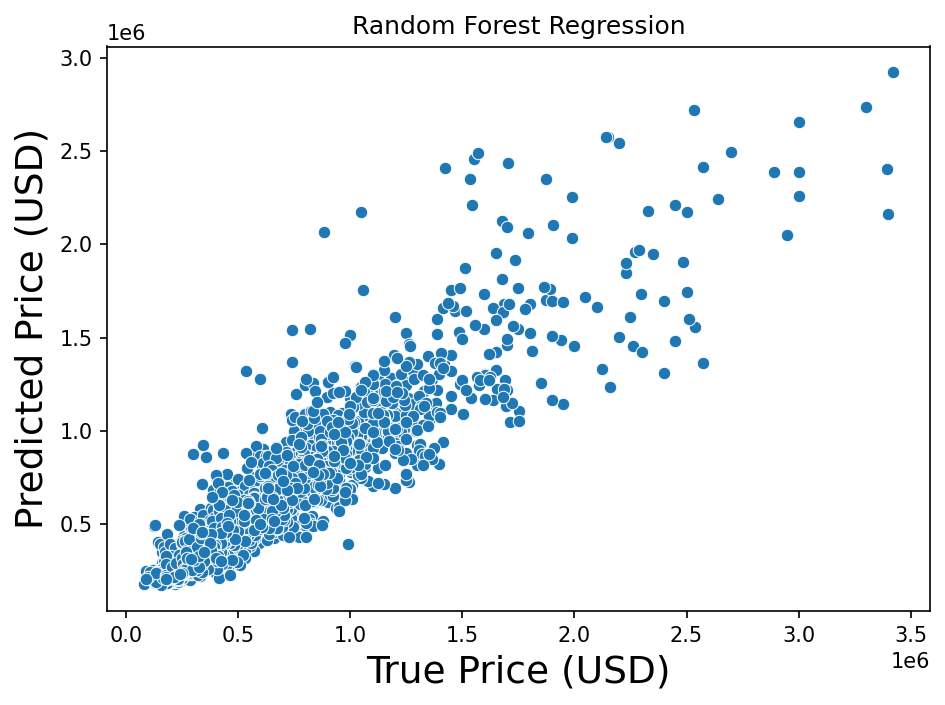

In [20]:
pred_true_plot = sns.scatterplot(x=test_y, y=pred_y)
pred_true_plot.set(xlabel="True Price (USD)", ylabel="Predicted Price (USD)", title="Random Forest Regression");

We get a better RMSE and MAPE but the algorithm took many times longer to complete.